<div align="center"><h1>
Modeling The CMB Frequency Spectrum with COBE/FIRAS
</h1>
<h2>By: Katherine Lee</h2>
</div>
<hr style="border:2px solid gray"> </hr>

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import emcee as mc
from corner import corner

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable

from IPython.display import display, Math
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from astropy.visualization import quantity_support

quantity_support()
set_matplotlib_formats('svg')
from matplotlib import cm
from cycler import cycler
plt.rc('legend', frameon = False)
plt.rc('figure', figsize = (7, 7/1.25))
plt.rc('font', size = 14)

## 1. Introduction

We're using data from Table 4 of [Fixsen et. al. (1996)](https://articles.adsabs.harvard.edu/pdf/1996ApJ...473..576F), which consists of frequencies in cm$^{-1}$, as well as residuals, uncertainties, and a model of the Milky Way, all in kJy/sr. There is also an artificial monopole spectrum included, which is produced by adding a 2.725 K blackbody spectrum to the given residuals. This seems to be the current accepted value for T$_0$, although it is not the one actually reported in Fixsen et. al. (1996). 

It might be useful to make an alternate array of frequencies in s$^{-1}$, depending on how you plan on formatting your models, but is not technically necessary.

First, let's read in the data:

In [2]:
#get the data
names = ["freq", "monopole", "res", "sigma", "gal"]
tmp = pd.read_csv("https://lambda.gsfc.nasa.gov/data/cobe/firas/monopole_spec/firas_monopole_spec_v1.txt", delim_whitespace = True, header = 0, skiprows = 17, names = names)
unit_names = ["cm-1", "MJy/sr", "kJy/sr", "kJy/sr", "kJy/sr"]
units = {names[i]:unit_names[i] for i in range(len(names))}
firas = QTable.from_pandas(tmp, units = units)

#make a version of the frequency in s-1
firas_freq = firas["freq"].to('GHz', equivalencies = u.spectral())

C:\Users\lasse\AppData\Local\Temp\ipykernel_10656\3489528096.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv("https://lambda.gsfc.nasa.gov/data/cobe/firas/monopole_spec/firas_monopole_spec_v1.txt", delim_whitespace = True, header = 0, skiprows = 17, names = names)


In [3]:
def blackbody(nu, T):
    """
    Return standard CMB blackbody in MJy/sr
    You can use astropy constants, i.e., c.k_B, and astropy units, u.sr, u.GHz, ec.
    """
    h = const.h
    c = const.c
    k = const.k_B
    return (
        2
        * h
        * nu**3
        / (c * c)
        / np.expm1((h * nu / (k * T)).decompose())
        / (u.sr)  # needs rad^-2 units to convert to MJy/sr
    ).to("MJy/sr")

and plot the monopole data, with the quoted $T_0$ blackbody to compare.

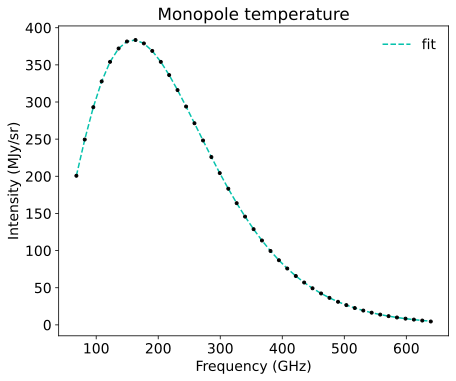

In [4]:
T = 2.725 * u.K  # T0 cmb temp

plt.figure()
plt.errorbar(firas_freq, firas["monopole"], yerr=firas["sigma"], fmt="k.")
plt.plot(
    firas_freq.to("GHz"),
    blackbody(firas_freq, T),
    color="xkcd:turquoise",
    ls="--",
    label="fit",
)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (MJy/sr)")
plt.title("Monopole temperature")
plt.legend()

### Consistency check 1

The error bars are smaller than the fit line.

1. Plot the error bars scaled by a sufficiently large factor.
2. Note the frequencies where the error bars are noticeably larger. What could cause this relative increase?

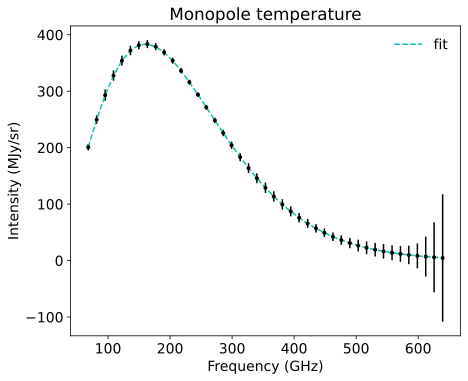

In [5]:
# Plot with errorbars enlargened
scale = 400  # scale factor for error bars

plt.figure()
plt.errorbar(firas_freq, firas["monopole"], yerr=firas["sigma"] * scale, fmt="k.")
plt.plot(
    firas_freq.to("GHz"),
    blackbody(firas_freq, T),
    color="xkcd:turquoise",
    ls="--",
    label="fit",
)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (MJy/sr)")
plt.title("Monopole temperature")
plt.legend()

The relative increase in error at the higher frequencies (around 500 GHz and greater) could be caused by ...

## 2. Fitting the data

How do we know that this temperature is actually the most likely value? We can use `emcee` to reproduce the temperature used to generate the monopole data. If you've never used `emcee` before, a tutorial can be found in the [documentation](https://emcee.readthedocs.io/en/stable/tutorials/line/).

We will first define the log-likelihood function for our model assessment. This will be passed into `emcee`.

### Consistency check 2

The blackbody spectrum is given mathematically by
$$
S_\nu(T)=\frac{2h\nu^3}{c^2}\frac1{e^{h\nu/kT}-1}.
$$
Assuming that the noise $S_\mathrm{err}$ describes Gaussian noise, such that
$$
d_\nu=S_\nu(T) + n_\nu
$$
where $n_\nu\sim\mathcal N(0,S_\mathrm{err}^2)$, derive the log-likelihood and code it in the next section.


Potential pitfalls:

1. Make sure that $h\nu/kT$ is unitless.
2. Make sure that the model and the data have the same units, MJy/sr.
3. $e^{h\nu/kT}-1$ can be very close to zero. The numpy function `np.expm1` may be useful for numerical stability.

In order to assess the goodness of fit, you need to estimate how model differs from the data, relative to the frequency. Essentially, is $d_\nu -S_\nu(T)$ given by a normal distribution?

The main idea is that we can think of the observed data as a true signal, plus some noise. Mathematically, we can represent this as a function $f(\theta)$ and some Gaussian noise, $n$, which is drawn from a normal distribution with mean zero and standard deviation sigma.

If we accept this, the data itself should have a mean $f(\theta)$, and each data point $d$ will be $f(\theta) + n$.

Given a single data point and a parameter $\theta$, we can compute the total difference between the data and the prediction, $d - f(\theta)$. Because there's noise, there should be some difference between $f(\theta)$ and $d$, $n$. If we have the right model, then we expect $d - f(\theta)$ to be drawn from a random Gaussian with standard deviation sigma, mean 0.

In this case, we expect the probability of observing a single data point d to be given by

$$
P(d \mid \theta, \sigma) = \frac1{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(d-\theta)^2}{2\sigma^2}\right)
$$

If we have multiple measurements, call them $\vec d=\{d_1,...d_N\}$, we can imagine that each data point is the realization of a random process, so that we can write

$$
P(\vec d\mid\theta,\sigma)=\prod_{i=1}^N\frac1{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{(d_i-\theta)^2}{2\sigma_i^2}\right)
$$

The idea behind the likelihood is that the data vector itself is fixed, and we want to infer what the value of $\theta$ is. In principle, we write a new function, $L(\theta) = P(d|\theta,\sigma)$, which is mathematically identical, but philosophically, it is now a function of $\theta$, whereas $P(d | \theta,\sigma)$ is a function of the data.

The main idea of maximizing the likelihood is that this will give us some idea of what the "most probable" value of $\theta$ is, given the data that we've observed. In practice, we take the natural logarithm of the likelihood, because mathematically, the value of \theta that maximizes $L(\theta)$ will also maximize $\log(L(\theta))$. If we try to calculate $L(\theta)$ directly, we will get numerical underflow in the computer, and lose most of the information. $\log(L)$ gives the same information, just transformed.

Another way to think of the log-likelihood is similar to how we think about $\chi^2$. As you probably saw before, 

$$
\chi^2(\theta)=\sum_{i=1}^N \frac{(d_i-f(\theta))^2}{\sigma_i^2}.
$$

This can be thought of minimizing the total distance of the data point from the theory curve, but normalizing it by how sensitive each data point is. If $\sigma_1 = 1000 \sigma_0$, then we know that $d_1$ is about a million times less informative, which should make some sort of sense if we think about what it means to get more sensitive measurements.

The log-likelihood is very similar to $\chi^2$, and it's pretty easy to show that $L(\theta) \propto e^{-\chi^2/2}$. Essentially, chi-squared minimization gives the exact same result as likelihood (or log-likelihood) maximization.

**Write down the expression for the likelihood, assuming that all of the data points are given, then code it up in the next code block.**

**The answer is...**

$$L(\theta) =   \prod_{i=1}^N \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left[ - \frac{(d_i - \theta)^2}{2\sigma_i^2} \right]$$ 
<!-- or
$$ = \sum_i^N \frac{1}{\sqrt{2\pi \sigma_i^2}} e^{- \chi^2/2}$$
With
$$\chi^2(\theta)= \sum_i^N \frac{(d_i - \theta)^2}{\sigma_i^2} $$  -->

Applying the natural logarithm, for numerical stability, we get
\begin{align*}
    \ln{L(\theta)} &= \ln\left[\prod_{i=1}^N \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left( - \frac{(d_i - \theta)^2}{2\sigma_i^2}\right) \right]
    \\ & = \sum_i^N \ln\left[\frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left( - \frac{(d_i - \theta)^2}{2\sigma_i^2}\right)\right]
    \\ &= \sum_i^N \left[-\frac{1}{2} \ln(2\pi \sigma_i^2) - \frac{(d_i - \theta)^2}{2\sigma_i^2}  \right]
    \\ &= -\sum_i^N \left[\frac{1}{2} \left(\ln2\pi + 2\ln\sigma_i\right) + \frac{(d_i - \theta)^2}{2\sigma_i^2}  \right]
\end{align*}

Neglecting the constant terms which will not differ, we can instead minimize the following
\begin{align*}
    -\sum_i^N \left[\ln\sigma_i^2 + \frac{(d_i - \theta)^2}{2\sigma_i^2}  \right]
\end{align*}


<!-- $$=-\frac{1}{2}\left[\left(\ln2 +  \ln(\Pi_i\sigma_i^2)\right)\right] - \chi^2$$
$$=-\frac{1}{2}\left[\left(\ln2 +  2\sum_i\ln(\sigma_i)\right)\right] - \chi^2$$
Here I choose to ignore the negligible $\frac{1}{2}\ln 2$ term:
$$=-\sum_i\ln\sigma_i - \chi^2$$
$$=-\sum_i \left(\frac{(d_i(\vec{p}) - d_i)^2}{\sigma_i^2} + \ln\sigma_i\right)$$ -->

In [6]:
# log likelihood function:
def log_LBB(T, nu, S, Serr):
    # T is temperature in Kelvin
    # nu is frequency in s-1
    # S is the monopole spectrum in MJy/sr
    # and Serr is the error in kJy/sr

    S_model = blackbody(nu, T)  # MJy/sr

    # Convert to MJy/sr
    Serr = Serr.to("MJy/sr")

    return -np.sum(0.5 * ((S_model - S)/Serr)**2 + np.log(Serr.value))

Then we will run the `emcee` chain! We will need to define a few things to get `emcee` to run:
A random seed, the chain length, as well as a initial position for the sampler to explore from.

In [7]:
#run mcmc
np.random.seed(42)
chain_len = 3000
T_ini = 2.7*u.K
# Draw initial positions for each of the walkers
pos = T_ini + 1e-3*np.random.randn(32, 1)*u.K
nwalkers, ndim = pos.shape

# Run the sampler
sampler = mc.EnsembleSampler(nwalkers, ndim, log_LBB, args = (firas_freq, firas["monopole"], firas["sigma"]))
sampler.run_mcmc(pos, chain_len, progress = True);

 19%|█▉        | 576/3000 [00:44<03:02, 13.30it/s]

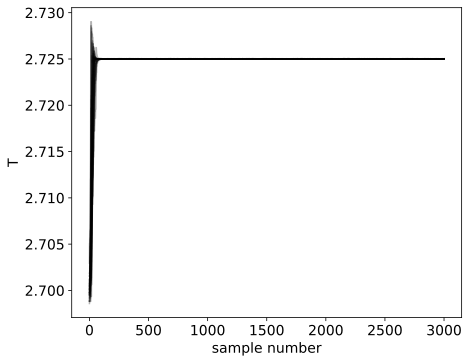

In [ ]:
#get all samples:
samples = sampler.get_chain()

#plot samples over time
plt.figure()
plt.plot(samples[:, :, 0], "k", alpha = 0.3)
plt.ylabel("T")
plt.xlabel("sample number");

## Consistency check 3

The autocorrelation length (see https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) is an estimate for how many samples must be separated by to be considered independent. Using the estimate of the autocorrelation length $\tau$, see how many integer multiples of $\tau$ are necessary to see if the chain is truly burned in.

If the chain is truly converged, a good rule of thumb is that it should look like a "hairy caterpillar". Comment on whether this seems like a good metric, and if you agree with it.

[26.93399364]


C:\Users\lasse\AppData\Local\Temp\ipykernel_10252\2938591222.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  burn_in = 3 * int(tau)


Text(0.5, 0, 'sample number')

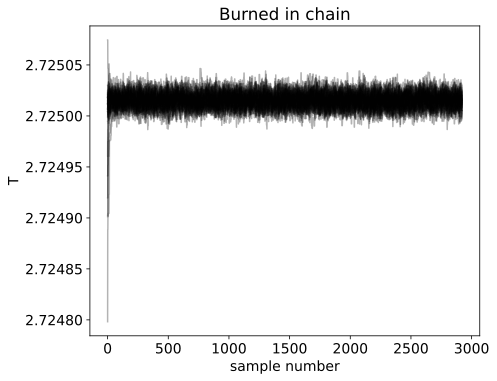

In [ ]:
# get autocorrelation time:
tau = sampler.get_autocorr_time()
print(tau)

burn_in = 3 * int(tau)


# plot samples over time
plt.figure()
plt.plot(samples[burn_in:, :, 0], "k", alpha=0.3)
plt.title("Burned in chain")
plt.ylabel("T")
plt.xlabel("sample number")

In [ ]:
# print final estimate
flat_samples = sampler.get_chain(discard=burn_in, thin=int(tau), flat=True)
T_mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84])
q = np.diff(T_mcmc)

txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(T_mcmc[1], q[0], q[1], "T")
display(Math(txt))

C:\Users\lasse\AppData\Local\Temp\ipykernel_10252\36269677.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_samples = sampler.get_chain(discard=burn_in, thin=int(tau), flat=True)


<IPython.core.display.Math object>

## Consistency check 4

Fixsen (2009) (https://ui.adsabs.harvard.edu/abs/2009ApJ...707..916F/abstract) is the widely-cited paper that contains the final temperature estimate of the FIRAS instrument. How does your result compare with these results? Comment on any notable differences, and posit a possible explanation.

#### Short answer

The cited source presents the FIRAS' temperature estimate of the CMB to be $(2.7260\pm0.0013)\ K$, while the mean of the literature estimates in table 2 is $(2.72548\pm0.00057)\ K$. My result falls within the uncertainties compared to the mean estimate, the difference between the mean/midpoint value being $0.47\ mK$ while the estimate uncertainty is greater: $0.57\ mK$. The notable difference here is my uncertainty is surpisingly low of $8\ \mu K$, which is two orders of magnitude lower than the estimate uncertainty.

# Spectral Distortions

Now, we'll use the residuals to sample the spectral distortions, or the differences between the FIRAS data and a pure blackbody spectrum. These spectral distortions originate from energy that has been injected into the early universe, causing the system to be at a slightly higher energy state than that of pure equilibrium. We use two different parameters to quantify these distortions: $\mu$ and $y$. These represent energy injections from high-energy scattering events at higher redshifts, and Compton scattering at lower redshifts, respectively (Fixsen et. al. 1996). 

Sunyaev and Zeldovich (1970) state that the source of $\mu$-type spectral distortions is that prior to recombination and decoupling, at redshifts between $10^5 < z < 3\times 10^6$, "bremsstrahlung processes are not able to maintain complete thermodynamic equilibrium between matter and radiation. Meanwhile the transfer of energy between electrons and photons due to scattering occurs sufficiently quickly for a Bose-Einstein distribution to be established." So basically, electrons and such are being excited at a high enough rate that the energy bound up in them can't be radiated away fast enough for the plasma to reach equilibrium, creating a chemical potential $\mu$.

According to Fixsen et. al. (1996), the effect of $y$-distortions is to produce "a Comptonized spectrum, [i.e.] a mixture of blackbodies at a range of temperatures." These typically come into play at $z<10^5$, and Chluba (2005) implies that they can also be created after decoupling by the Sunyaev-Zeldovich effect.

### Consistency check 4

At this point in the analysis, it is helpful to assume that we basically have the correct temperature, $T_0$, and any corrections will be small, and given by $\Delta T$. This means that the data can be modeled as
$$
B_\nu(T_0+\Delta T)-B_\nu(T_0)\simeq\,\Delta T
\left.\frac{\partial B_\nu}{\partial T}\right|_{T=T_0}
$$

Derive the spectrum of the deviations from the ideal blackbody, $\partial B_\nu/\partial T$.

We differentiate the expression for the blackbody radiation/Planck's law with respect to the temperature T:

\begin{align*}
    \frac{\partial B_\nu}{\partial T} &= \frac{2h\nu^3}{c^2} \frac{d}{\partial T}\left( \frac{1}{e^{h\nu/kT} - 1} \right)
    \\ &= \frac{2h\nu^3}{c^2} \left[ -\frac{1}{(e^{h\nu/kT} - 1)^2} e^{h\nu/kT} \left(-\frac{h\nu}{kT^2}\right) \right]
    \\ &= \frac{2h^2\nu^4}{c^2kT^2}\frac{e^{h\nu/kT}}{(e^{h\nu/kT} - 1 )^2}
\end{align*}

Such that 
$$\Delta T
\left.\frac{\partial B_\nu}{\partial T}\right|_{T=T_0} = \Delta T \frac{2h^2\nu^4}{c^2kT_0^2}\frac{e^{h\nu/kT_0}}{(e^{h\nu/kT_0} - 1 )^2}
$$

Now we want to sample for any potential distortions in the spectrum, whether $\mu$ or $y$ type. Again we'll need to define log-likelihood functions for the spectral distortion distributions. Before we do that, let us define functional forms for both of the distortion types, $\mu$ and $y$.


### Consistency check 5

A $\mu$-type distribution is equivalent to a Bose-Einstein distribution with chemical potential $\mu$,
$$
I_\nu^\mathrm{BE}=\frac{2h\nu^3}{c^2}\frac{1}{e^{x+\mu}-1}
$$
where $x=h\nu/kT$.

Derive the first order correction, $I_\nu^\mathrm{SD,\mu}=\mu\frac{\partial I_\nu}{\partial \mu}$.

We differentiate the above expression with respect to the chemical potential $\mu$

\begin{align*}
    I_\nu^{SD,\mu} &= \mu \frac{\partial I_\nu}{\partial \mu}
    \\ &= \mu \frac{2h\nu^3}{c^2} \left[ -\frac{1}{(e^{x+\mu}-1)^2} e^{x+\mu} \right]
    \\ &= -\frac{2h\nu^3\mu }{c^2}\frac{e^{x+\mu}}{(e^{x+\mu} - 1 )^2}
    \\ &= -\frac{2h\nu^3\mu}{c^2}\frac{e^{x+\mu}}{(e^{x+\mu} - 1 )^2}
\end{align*}

 
 A similar approach can be followed to separate $y$ distortion map, where the emission law is
 
 
\begin{equation}
I_{\nu}^{\mathrm{SD},y} = yT_0 \Big(x\frac{\exp{x}+1}{\exp{x}-1}-4\Big)\frac{\partial B_\nu}{\partial T}\Big|_{T=T_0}."
\end{equation}


The above equations are the functions which we need to evaluate in order to fit for the spectral parameter. Let's do that now:

In [ ]:
def dBdT(nu, T=2.725 * u.K):
    # nu is frequency in s-1
    h = const.h
    k = const.k_B
    c = const.c
    x = h * nu / (k * T)

    return (
        2 * h * h * nu**4 / (c * c * k * T * T) * np.exp(x) / (np.expm1(x)) ** 2
    ) / u.sr  # needs same unit as blackbody rad, then per kelvin


def func_mu(nu, mu, T=2.725):
    # nu is frequency in s-1
    # mu is dimensionless
    # T is unitless or else emcee freaks out

    T = T * u.K
    h = const.h
    k = const.k_B
    c = const.c
    x = h * nu / (k * T)

    v = x.decompose() + mu
    return -2 * h * nu**3 * mu / (c*c) * np.exp(v) / (np.expm1(v)) ** 2


def func_y(nu, y, T=2.725):
    # nu is frequency in s-1
    # y is dimensionless
    # T is unitless or else emcee freaks out
    T = T * u.K
    h = const.h
    k = const.k_B
    x = h * nu / (k * T)

    return y * T * (x * (np.exp(x) + 1) / np.expm1(x) - 4) * dBdT(nu, T)

Define some likelihood functions here:

In [ ]:
def log_Ly(theta, nu, Sres, Serr):
    # nu is an array of frequencies in s-1
    # Sres and Serr are the residual and error arrays in kJy/sr
    y = theta
    model = func_y(nu, y)
    return -np.sum(0.5 * ((model - Sres) / Serr) ** 2 + np.log(Serr.value))


def log_Lmu(theta, nu, Sres, Serr):
    mu = theta
    model = func_mu(nu, mu)
    print(model.unit)
    print(Sres.unit)
    return -np.sum(0.5 * ((model - Sres) / Serr) ** 2 + np.log(Serr.value))

Before we try sampling for each of the parameters ($T$, $\mu$, $y$) together, let's do them one at a time. Now setting up `emcee` for $y$: 

In [ ]:
#mcmc for y:
np.random.seed(42)
chain_len = 2000
y_ini = -1e-6
pos_y = y_ini + 1e-6*np.random.randn(32, 1)
nwalkers_y, ndim_y = pos_y.shape

sampler_y = mc.EnsembleSampler(nwalkers_y, ndim_y, log_Ly, args = (firas_freq, firas["res"], firas["sigma"]))
sampler_y.run_mcmc(pos_y, chain_len, progress = True);

You must install the tqdm library to use progress indicators with emcee


Now for $\mu$:

In [ ]:
mu_ini = -1e-5
pos_mu = mu_ini + 1e-6*np.random.randn(32, 1)
nwalkers_mu, ndim_mu = pos_mu.shape

sampler_mu = mc.EnsembleSampler(nwalkers_mu, ndim_mu, log_Lmu, args = (firas_freq, firas["res"], firas["sigma"]))
sampler_mu.run_mcmc(pos_mu, chain_len, progress = True);

emcee: Exception while calling your likelihood function:
  params: [-9.70387972e-06]
  args: (<Quantity [ 68.05288797,  81.54354858,  95.33400164, 108.82466225,
           122.31532286, 136.10577593, 149.59643654, 163.38688961,
           176.87755022, 190.36821083, 204.1586639 , 217.64932451,
           231.13998512, 244.93043819, 258.4210988 , 272.21155186,
           285.70221247, 299.19287308, 312.98332615, 326.47398676,
           339.96464737, 353.75510044, 367.24576105, 381.03621412,
           394.52687473, 408.01753534, 421.80798841, 435.29864902,
           448.78930963, 462.57976269, 476.0704233 , 489.86087637,
           503.35153698, 516.84219759, 530.63265066, 544.12331127,
           557.91376434, 571.40442495, 584.89508556, 598.68553863,
           612.17619924, 625.66685985, 639.45731291] GHz>, <Quantity [   5.,    9.,   15.,    4.,   19.,  -30.,  -30.,  -10.,   32.,
              4.,   -2.,   13.,  -22.,    8.,    8.,  -21.,    9.,   12.,
             11.,  -29.,  -46

Traceback (most recent call last):
  File "c:\Users\lasse\Documents\Dev\UiO\AST3220\.venv\Lib\site-packages\astropy\units\quantity_helper\helpers.py", line 77, in get_converters_and_unit
    converters[changeable] = get_converter(unit2, unit1)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lasse\Documents\Dev\UiO\AST3220\.venv\Lib\site-packages\astropy\units\quantity_helper\helpers.py", line 42, in get_converter
    converter = from_unit.get_converter(to_unit)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lasse\Documents\Dev\UiO\AST3220\.venv\Lib\site-packages\astropy\units\core.py", line 1156, in get_converter
    raise exc
  File "c:\Users\lasse\Documents\Dev\UiO\AST3220\.venv\Lib\site-packages\astropy\units\core.py", line 1139, in get_converter
    return self._apply_equivalencies(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lasse\Documents\Dev\UiO\AST3220\.venv\Lib\site-packages\astropy\units\core.py", line 1090, in _apply_e

UnitConversionError: Can only apply 'subtract' function to quantities with compatible dimensions

Let's plot the chains to visualize convergence.

In [ ]:
#get autocorrelation time:
tau_y = 
tau_mu = 
print(tau_y, tau_mu)

#get all samples:
samples_y = 
samples_mu = 
#print(samples_y.shape, samples_mu.shape)

#plot samples over time
fig, axes = plt.subplots(sharex=True, nrows=2)
axes[0].plot()
axes[0].set_ylabel(r"$y$")
axes[1].plot()
axes[1].set_ylabel(r"$\mu$")
axes[1].set_xlabel("sample number");

In [ ]:
flat_samples_y = sampler_y.get_chain(discard = , thin = int(tau_y), flat = True)
y_mcmc = np.percentile(flat_samples_y[:, 0], [16, 50, 84])
q_y = np.diff(y_mcmc)

flat_samples_mu = sampler_mu.get_chain(discard = , thin = int(tau_mu), flat = True)
mu_mcmc = np.percentile(flat_samples_mu[:, 0], [16, 50, 84])
q_mu = np.diff(mu_mcmc)

txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt_y = txt.format(y_mcmc[1], q_y[0], q_y[1], "y")
txt_mu = txt.format(mu_mcmc[1], q_mu[0], q_y[1], "\mu")
display(Math(txt_y))
display(Math(txt_mu))

Now that we have made the functional forms for each of our parameters, we'll sample all at once! As before, we need to define a overall log-likelihood function to pass into `emcee`. A large benefit of using the log-likelihood is that one can combine log-likelihoods linearly!

In [ ]:
def log_Ltot(theta, nu, S, Sres, Serr):
    T, y, mu = theta
    T = T*u.K 
    return log_LBB(T, nu, S, Serr) + log_Ly(y, nu, Sres, Serr) + log_Lmu(mu, nu, Sres, Serr)

pos_tot = [T_ini.value, y_ini, mu_ini] + 1e-6*np.random.randn(32, 3)
nwalkers_tot, ndim_tot = pos_tot.shape

sampler_tot = mc.EnsembleSampler(nwalkers_tot, ndim_tot, log_Ltot, args = (firas_freq, firas["monopole"], firas["res"], firas["sigma"]))
sampler_tot.run_mcmc(pos_tot, chain_len, progress = True);

As before, let's plot the chains for each of the parameters.

In [ ]:
samples = sampler_tot.get_chain()

fig, axes = plt.subplots(sharex=True, nrows=3)
labels=[r'$T_0$', r'$y$', r'$\mu$']
for i in range(3):
    axes[i].plot(samples[50:, :, i], "k", alpha = 0.3)
    axes[i].set_ylabel(labels[i])
    axes[i].yaxis.set_label_coords(-0.1, 0.5)
axes[2].set_xlabel("sample number");

Again, use the autocorrelation length to estimate the burnin.

In [ ]:
samples = sampler_tot.get_chain()

fig, axes = plt.subplots(sharex=True, nrows=3)
labels=[r'$T_0$', r'$y$', r'$\mu$']
for i in range(3):
    axes[i].plot()
    axes[i].set_ylabel(labels[i])
    axes[i].yaxis.set_label_coords(-0.1, 0.5)
axes[2].set_xlabel("sample number");

In [ ]:
flat_samples = sampler_tot.get_chain(discard = , thin = int(tau_y), flat = True)
txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.6f}}}^{{{2:.6f}}}"
labels = ["T_0", "y", "\mu"]
for i in range(ndim_tot):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt_0 = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt_0))

It is definitely useful to get an idea of how good of a fit our model is to our data, so we will define a simple sum of least-square function to evaluate. Luckily, the log-likelihood function that we've defined for the model evaluation is already written, and can be re-used to define our goodness-of-fit.

In [ ]:
chisq = np.zeros((flat_samples.shape[0], 1))
for i in range(flat_samples.shape[0]):
    theta = [flat_samples[i, 0], flat_samples[i, 1], flat_samples[i, 2]]
    chisq[i] = log_Ltot(theta, firas_freq, firas["monopole"], firas["res"], firas["sigma"])*-2.0

A good way to check how correlated or degenerate parameters are can be to plot corner plots ([python package](https://corner.readthedocs.io/en/latest/pages/quickstart/)). So let's give that a try here:

In [ ]:
print(chisq.shape, flat_samples.shape)
corner_data = np.concatenate((flat_samples[250:,:], chisq[250:,:]), axis = 1)
corner(corner_data, show_titles = True, labels = [r"T$_0$", r"$y$", r"$\mu$", r"$\chi^2$"], title_fmt = ".3e")
plt.tight_layout();

In [ ]:
y_mcmc = np.percentile(flat_samples[:, 1], 50)
mu_mcmc = np.percentile(flat_samples[:, 2], 50)

plt.figure()
plt.plot(firas_freq, firas["res"], "k", lw = 1)
plt.plot(firas_freq, (func_mu(firas_freq, mu_mcmc)), color = 'xkcd:turquoise', ls = "--", label = "fit (mu)")
plt.plot(firas_freq, (func_y(firas_freq, y_mcmc)), color = 'xkcd:orange', ls = "-.", label = "fit (y)")
plt.ylim([-50, 50])
plt.xlabel(r"Frequency (s$^{-1}$)")
plt.ylabel("Residual intensity (kJy/sr)")
plt.title("Fits to residuals")
plt.tight_layout()
plt.legend();

### Final consistency check

We have not yet currently derived $y$-distortions or $\mu$-distortions, so upper limits may be more appropriate to fit for. How would you report the results as upper limits rather than measurements centered around zeros?


As a second point, the limits we derived are much tighter than the official limits. What are some potential sources of this difference? (There are many correct answers to this!)

*I hypothesisize that...*